In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error as mae, r2_score, mean_squared_error as mse, accuracy_score
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from gensim.parsing.preprocessing import strip_punctuation, remove_stopwords, strip_non_alphanum
from tqdm import tqdm

%matplotlib inline

# Data preprocessing

In [6]:
# Load data from csv
df = pd.read_csv('../datasets/goodreads-300k-dataset/goodreads.csv')

# Split rating count
rating_count_split = 1000
df = df[df.rating_count >= rating_count_split]

# Combine title and description into one
df['title_description'] = df[['title', 'description']].apply(lambda x: ' '.join(x), axis=1)

# Remove non-ascii rows
df = df[df.title_description.map(lambda x: x.isascii())]

# Convert to lowercase
df.title_description = df.title_description.str.lower()

# Remove punctuation
df.title_description = df.title_description.apply(lambda x: strip_punctuation(x))

# Remove stopwords
df.title_description = df.title_description.apply(lambda x: remove_stopwords(x))

# Remove non-alpha
df.title_description = df.title_description.apply(lambda x: strip_non_alphanum(x))

/var/folders/8r/m2pg_8ks4llg947g5m_m0hqh0000gn/T/ipykernel_52723/1304180350.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('goodreads-300k-dataset/goodreads.csv')


# Linear Regression

In [16]:
train_df, valid_df = train_test_split(df, test_size=0.1, random_state=1)

print('Train:', train_df.shape)
print('Valid:', valid_df.shape)

Train: (45576, 11)
Valid: (5064, 11)


In [17]:
# Word embedding
vectorizer = TfidfVectorizer()
vectorizer.fit(df.title_description)

X_train = vectorizer.transform(train_df.title_description)
X_valid = vectorizer.transform(valid_df.title_description)

y_train = train_df.rating.values
y_valid = valid_df.rating.values

In [18]:
train_mae = []
valid_mae = []
train_mse = []
valid_mse = []
train_r2 = []
valid_r2 = []

KBest = np.arange(100, 10000, 50)
for i in tqdm(KBest):
    select = SelectKBest(score_func=f_regression, k=i)
    select.fit(X_train, y_train)
    
    X_train_selected = select.transform(X_train)
    X_valid_selected = select.transform(X_valid)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_train_selected)
    train_mae.append(mae(y_train, y_pred))
    train_mse.append(mse(y_train, y_pred))
    train_r2.append(r2_score(y_train, y_pred))

    y_pred = model.predict(X_valid_selected)
    valid_mae.append(mae(y_valid, y_pred))
    valid_mse.append(mse(y_valid, y_pred))
    valid_r2.append(r2_score(y_valid, y_pred))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [13:18<00:00,  4.03s/it]


2000

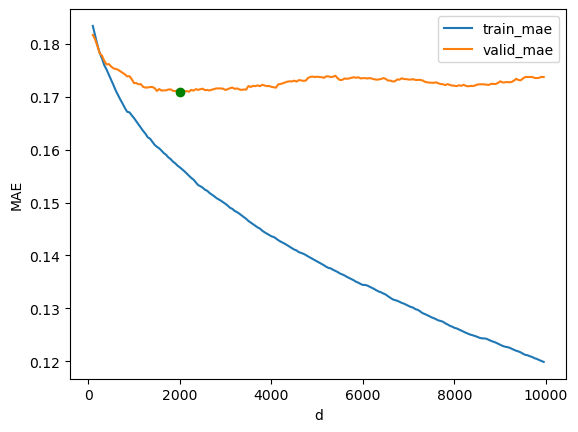

In [19]:
plt.plot(KBest, train_mae, label='train_mae')
plt.plot(KBest, valid_mae, label='valid_mae')

x_best = KBest[np.argmin(valid_mae)]
y_best = np.min(valid_mae)
plt.plot(x_best, y_best, marker="o", color="green")

plt.xlabel('d')
plt.ylabel('MAE')
plt.legend()
plt.savefig('SelectKBest_MAE.png')
x_best

1500

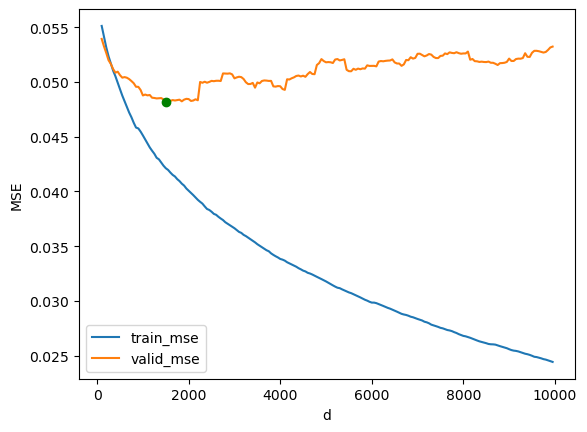

In [20]:
plt.plot(KBest, train_mse, label='train_mse')
plt.plot(KBest, valid_mse, label='valid_mse')

x_best = KBest[np.argmin(valid_mse)]
y_best = np.min(valid_mse)
plt.plot(x_best, y_best, marker="o", color="green")

plt.xlabel('d')
plt.ylabel('MSE')
plt.legend()
plt.savefig('SelectKBest_MSE.png')
x_best

1500

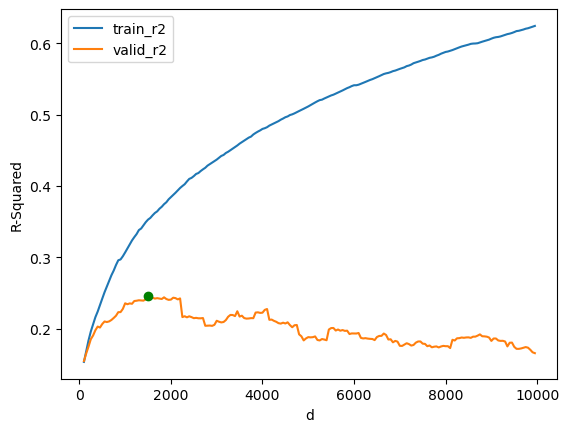

In [21]:
plt.plot(KBest, train_r2, label='train_r2')
plt.plot(KBest, valid_r2, label='valid_r2')

x_best = KBest[np.argmax(valid_r2)]
y_best = np.max(valid_r2)
plt.plot(x_best, y_best, marker="o", color="green")

plt.xlabel('d')
plt.ylabel('R-Squared')
plt.legend()
plt.savefig('SelectKBest_R2.png')
x_best

# Logistic Regression

In [7]:
# Binning label
bins = (0, 3, 3.5, 4, 4.5, 5)
labels = np.arange(len(bins)-1)
df.rating = pd.cut(df.rating, bins=bins, labels=labels, include_lowest=True)

In [13]:
train_df, valid_df = train_test_split(df, test_size=0.1, random_state=1)

print('Train:', train_df.shape)
print('Valid:', valid_df.shape)

Train: (45576, 11)
Valid: (5064, 11)


In [14]:
# Word embedding
vectorizer = TfidfVectorizer()
vectorizer.fit(df.title_description)

X_train = vectorizer.transform(train_df.title_description)
X_valid = vectorizer.transform(valid_df.title_description)

y_train = train_df.rating.values
y_valid = valid_df.rating.values

In [18]:
train_acc = []
valid_acc = []

KBest = np.arange(1000, 100000, 1000)
for i in tqdm(KBest):
    select = SelectKBest(score_func=f_regression, k=i)
    select.fit(X_train, y_train)
    
    X_train_selected = select.transform(X_train)
    X_valid_selected = select.transform(X_valid)

    model = LogisticRegression(multi_class='multinomial', max_iter=1000)
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_train_selected)
    train_acc.append(accuracy_score(y_pred, y_train))

    y_pred = model.predict(X_valid_selected)
    valid_acc.append(accuracy_score(y_pred, y_valid))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [12:42<00:00,  7.70s/it]


92000

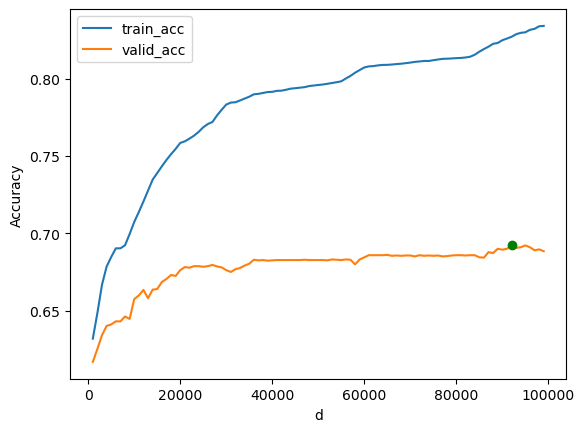

In [19]:
plt.plot(KBest, train_acc, label='train_acc')
plt.plot(KBest, valid_acc, label='valid_acc')

x_best = KBest[np.argmax(valid_acc)]
y_best = np.max(valid_acc)
plt.plot(x_best, y_best, marker="o", color="green")

plt.xlabel('d')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('SelectKBest_ACC.png')
x_best